## Load normalized data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import models
from keras import layers
import numpy as np

normalized_data = pd.read_csv("normalized_data.csv", index_col=0)
normalized_data

Using TensorFlow backend.


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,...,SOTON/O.Q.,2.,W./C.,STON/O,CA.,A/5,SC/PARIS,2343,CA,A/5.
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.271174,0.2,0.000000,0.014151,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.472229,0.2,0.000000,0.139136,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.321438,0.0,0.000000,0.015469,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.434531,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,1.0,NaN,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,NaN,0.0,0.484795,0.0,0.000000,0.212559,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,NaN,1.0,0.478512,0.0,0.000000,0.014151,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Counting empty values

In [2]:
empty_values = [(label, normalized_data[label].isnull().sum()) for label in normalized_data.columns.values]
sorted(empty_values, reverse=True, key=lambda tup: tup[1])

[('Survived', 418),
 ('Age', 263),
 ('Pclass', 0),
 ('SibSp', 0),
 ('Parch', 0),
 ('Fare', 0),
 ('female', 0),
 ('male', 0),
 ('C', 0),
 ('Q', 0),
 ('S', 0),
 ('Mr', 0),
 ('Miss', 0),
 ('Mrs', 0),
 ('PC', 0),
 ('C.A.', 0),
 ('SOTON/O.Q.', 0),
 ('2.', 0),
 ('W./C.', 0),
 ('STON/O', 0),
 ('CA.', 0),
 ('A/5', 0),
 ('SC/PARIS', 0),
 ('2343', 0),
 ('CA', 0),
 ('A/5.', 0)]

## Separate samples with and without age

In [3]:
samples_with_age = normalized_data[normalized_data.Age.notna()]
samples_without_age = normalized_data[normalized_data.Age.isna()]

## Creating model for age prediction

In [4]:
x_train_age = samples_with_age.drop(["Age", "Survived"], axis=1).values
y_train_age = samples_with_age["Age"].values

number_of_epochs = 80
number_of_folds = 5
number_of_samples = len(x_train_age) // number_of_folds

all_mae_histories = []
all_val_mae_histories = []
for i in range(number_of_folds):
    print("processing fold #", i)
    partial_x_train_age = np.concatenate([x_train_age[:i*number_of_samples], x_train_age[(i+1)*number_of_samples:]])
    parital_y_train_age = np.concatenate([y_train_age[:i*number_of_samples], y_train_age[(i+1)*number_of_samples:]])
    
    partial_x_validation_age = x_train_age[i*number_of_samples:(i+1)*number_of_samples]
    partial_y_validation_age = y_train_age[i*number_of_samples:(i+1)*number_of_samples]

    model = models.Sequential()
    model.add(layers.Dense(x_train_age.shape[1], activation="relu", input_shape=(x_train_age.shape[1],)))
    model.add(layers.Dense(12, activation="relu"))
    model.add(layers.Dense(1))

    model.compile(optimizer="rmsprop",
                  loss="mse",
                  metrics=["mae"])

    history = model.fit(partial_x_train_age,
                        parital_y_train_age,
                        epochs=number_of_epochs,
                        batch_size=16,
                        validation_data=(partial_x_validation_age, partial_y_validation_age))
    all_mae_histories.append(history.history['mae'])
    all_val_mae_histories.append(history.history['val_mae'])


processing fold # 0
Train on 837 samples, validate on 209 samples
Epoch 1/80
837/837 [==============================] - 0s 267us/step - loss: 0.0525 - mae: 0.1757 - val_loss: 0.0291 - val_mae: 0.1342
Epoch 2/80
837/837 [==============================] - 0s 122us/step - loss: 0.0269 - mae: 0.1295 - val_loss: 0.0250 - val_mae: 0.1248
Epoch 3/80
837/837 [==============================] - 0s 117us/step - loss: 0.0242 - mae: 0.1213 - val_loss: 0.0238 - val_mae: 0.1184
Epoch 4/80
837/837 [==============================] - 0s 120us/step - loss: 0.0227 - mae: 0.1167 - val_loss: 0.0233 - val_mae: 0.1168
Epoch 5/80
837/837 [==============================] - 0s 123us/step - loss: 0.0217 - mae: 0.1140 - val_loss: 0.0243 - val_mae: 0.1165
Epoch 6/80
837/837 [==============================] - 0s 134us/step - loss: 0.0216 - mae: 0.1128 - val_loss: 0.0240 - val_mae: 0.1219
Epoch 7/80
837/837 [==============================] - 0s 122us/step - loss: 0.0213 - mae: 0.1118 - val_loss: 0.0235 - val_mae: 0.1

837/837 [==============================] - 0s 118us/step - loss: 0.0176 - mae: 0.1004 - val_loss: 0.0203 - val_mae: 0.1090
Epoch 62/80
837/837 [==============================] - 0s 113us/step - loss: 0.0174 - mae: 0.1002 - val_loss: 0.0203 - val_mae: 0.1084
Epoch 63/80
837/837 [==============================] - 0s 116us/step - loss: 0.0174 - mae: 0.0997 - val_loss: 0.0204 - val_mae: 0.1089
Epoch 64/80
837/837 [==============================] - 0s 110us/step - loss: 0.0174 - mae: 0.0992 - val_loss: 0.0202 - val_mae: 0.1098
Epoch 65/80
837/837 [==============================] - 0s 122us/step - loss: 0.0171 - mae: 0.0989 - val_loss: 0.0228 - val_mae: 0.1193
Epoch 66/80
837/837 [==============================] - 0s 110us/step - loss: 0.0172 - mae: 0.0997 - val_loss: 0.0204 - val_mae: 0.1090
Epoch 67/80
837/837 [==============================] - 0s 124us/step - loss: 0.0172 - mae: 0.0991 - val_loss: 0.0204 - val_mae: 0.1085
Epoch 68/80
837/837 [==============================] - 0s 114us/ste

837/837 [==============================] - 0s 128us/step - loss: 0.0171 - mae: 0.1005 - val_loss: 0.0210 - val_mae: 0.1120
Epoch 42/80
837/837 [==============================] - 0s 128us/step - loss: 0.0173 - mae: 0.1006 - val_loss: 0.0208 - val_mae: 0.1105
Epoch 43/80
837/837 [==============================] - 0s 119us/step - loss: 0.0169 - mae: 0.1000 - val_loss: 0.0209 - val_mae: 0.1102
Epoch 44/80
837/837 [==============================] - 0s 132us/step - loss: 0.0169 - mae: 0.1003 - val_loss: 0.0219 - val_mae: 0.1089
Epoch 45/80
837/837 [==============================] - 0s 117us/step - loss: 0.0171 - mae: 0.0996 - val_loss: 0.0207 - val_mae: 0.1097
Epoch 46/80
837/837 [==============================] - 0s 122us/step - loss: 0.0169 - mae: 0.0999 - val_loss: 0.0212 - val_mae: 0.1082
Epoch 47/80
837/837 [==============================] - 0s 121us/step - loss: 0.0170 - mae: 0.1001 - val_loss: 0.0203 - val_mae: 0.1091
Epoch 48/80
837/837 [==============================] - 0s 132us/ste

837/837 [==============================] - 0s 131us/step - loss: 0.0172 - mae: 0.0992 - val_loss: 0.0253 - val_mae: 0.1209
Epoch 22/80
837/837 [==============================] - 0s 120us/step - loss: 0.0171 - mae: 0.0999 - val_loss: 0.0245 - val_mae: 0.1238
Epoch 23/80
837/837 [==============================] - 0s 112us/step - loss: 0.0171 - mae: 0.0998 - val_loss: 0.0237 - val_mae: 0.1235
Epoch 24/80
837/837 [==============================] - 0s 127us/step - loss: 0.0170 - mae: 0.0994 - val_loss: 0.0245 - val_mae: 0.1206
Epoch 25/80
837/837 [==============================] - 0s 119us/step - loss: 0.0169 - mae: 0.0989 - val_loss: 0.0239 - val_mae: 0.1217
Epoch 26/80
837/837 [==============================] - 0s 119us/step - loss: 0.0167 - mae: 0.0977 - val_loss: 0.0253 - val_mae: 0.1306
Epoch 27/80
837/837 [==============================] - 0s 114us/step - loss: 0.0169 - mae: 0.0987 - val_loss: 0.0240 - val_mae: 0.1207
Epoch 28/80
837/837 [==============================] - 0s 128us/ste

837/837 [==============================] - 0s 232us/step - loss: 0.0592 - mae: 0.1868 - val_loss: 0.0355 - val_mae: 0.1467
Epoch 2/80
837/837 [==============================] - 0s 113us/step - loss: 0.0296 - mae: 0.1350 - val_loss: 0.0273 - val_mae: 0.1226
Epoch 3/80
837/837 [==============================] - 0s 125us/step - loss: 0.0256 - mae: 0.1246 - val_loss: 0.0244 - val_mae: 0.1180
Epoch 4/80
837/837 [==============================] - 0s 126us/step - loss: 0.0241 - mae: 0.1208 - val_loss: 0.0233 - val_mae: 0.1140
Epoch 5/80
837/837 [==============================] - 0s 117us/step - loss: 0.0234 - mae: 0.1194 - val_loss: 0.0225 - val_mae: 0.1135
Epoch 6/80
837/837 [==============================] - 0s 120us/step - loss: 0.0228 - mae: 0.1179 - val_loss: 0.0220 - val_mae: 0.1130
Epoch 7/80
837/837 [==============================] - 0s 119us/step - loss: 0.0220 - mae: 0.1157 - val_loss: 0.0220 - val_mae: 0.1146
Epoch 8/80
837/837 [==============================] - 0s 125us/step - los

Epoch 62/80
837/837 [==============================] - 0s 121us/step - loss: 0.0169 - mae: 0.0999 - val_loss: 0.0221 - val_mae: 0.1082
Epoch 63/80
837/837 [==============================] - 0s 131us/step - loss: 0.0169 - mae: 0.0998 - val_loss: 0.0217 - val_mae: 0.1093
Epoch 64/80
837/837 [==============================] - 0s 122us/step - loss: 0.0169 - mae: 0.0985 - val_loss: 0.0221 - val_mae: 0.1133
Epoch 65/80
837/837 [==============================] - 0s 126us/step - loss: 0.0166 - mae: 0.0982 - val_loss: 0.0221 - val_mae: 0.1099
Epoch 66/80
837/837 [==============================] - 0s 118us/step - loss: 0.0169 - mae: 0.0992 - val_loss: 0.0218 - val_mae: 0.1075
Epoch 67/80
837/837 [==============================] - 0s 192us/step - loss: 0.0166 - mae: 0.0986 - val_loss: 0.0216 - val_mae: 0.1114
Epoch 68/80
837/837 [==============================] - 0s 195us/step - loss: 0.0165 - mae: 0.0976 - val_loss: 0.0235 - val_mae: 0.1177
Epoch 69/80
837/837 [==============================] - 

837/837 [==============================] - 0s 122us/step - loss: 0.0174 - mae: 0.1001 - val_loss: 0.0210 - val_mae: 0.1192
Epoch 43/80
837/837 [==============================] - 0s 117us/step - loss: 0.0174 - mae: 0.1008 - val_loss: 0.0180 - val_mae: 0.1091
Epoch 44/80
837/837 [==============================] - 0s 135us/step - loss: 0.0174 - mae: 0.1005 - val_loss: 0.0186 - val_mae: 0.1101
Epoch 45/80
837/837 [==============================] - 0s 119us/step - loss: 0.0177 - mae: 0.1013 - val_loss: 0.0181 - val_mae: 0.1095
Epoch 46/80
837/837 [==============================] - 0s 132us/step - loss: 0.0174 - mae: 0.0997 - val_loss: 0.0183 - val_mae: 0.1113
Epoch 47/80
837/837 [==============================] - 0s 125us/step - loss: 0.0173 - mae: 0.0996 - val_loss: 0.0187 - val_mae: 0.1081
Epoch 48/80
837/837 [==============================] - 0s 129us/step - loss: 0.0171 - mae: 0.0993 - val_loss: 0.0199 - val_mae: 0.1105
Epoch 49/80
837/837 [==============================] - 0s 153us/ste

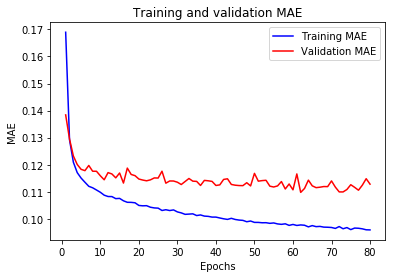

In [5]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(number_of_epochs)]
average_val_mae_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(number_of_epochs)]

epochs = range(1, number_of_epochs + 1)

plt.plot(epochs, average_mae_history, "b", label="Training MAE")
plt.plot(epochs, average_val_mae_history, "b", label="Validation MAE", c="red")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.show()

## Evaluate results for age prediction

In [6]:
results_age = model.predict(samples_without_age.drop(["Survived", "Age"], axis=1))
samples_without_age.loc[:,"Age"] = results_age
samples_without_age

/home/victor/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,...,SOTON/O.Q.,2.,W./C.,STON/O,CA.,A/5,SC/PARIS,2343,CA,A/5.
PassengerId,,,,,,,,,,,,,,,,,,,,,
6,0.0,1.0,0.453024,0.0,0.000000,0.016510,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1.0,0.5,0.420812,0.0,0.000000,0.025374,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,1.0,0.383475,0.0,0.000000,0.014102,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,1.0,0.331169,0.0,0.000000,0.014102,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,1.0,1.0,0.259966,0.0,0.000000,0.015379,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NaN,1.0,0.260001,0.0,0.000000,0.015070,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1302,NaN,1.0,0.259994,0.0,0.000000,0.015127,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,NaN,1.0,0.360627,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save data

In [7]:
normalized_data_with_predicted_age = pd.concat([samples_with_age, samples_without_age])
normalized_data_with_predicted_age.to_csv("normalized_data_with_predicted_age.csv", index=True)
normalized_data_with_predicted_age

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,...,SOTON/O.Q.,2.,W./C.,STON/O,CA.,A/5,SC/PARIS,2343,CA,A/5.
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.271174,0.2,0.000000,0.014151,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.472229,0.2,0.000000,0.139136,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.321438,0.0,0.000000,0.015469,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.434531,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NaN,1.0,0.260001,0.0,0.000000,0.015070,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1302,NaN,1.0,0.259994,0.0,0.000000,0.015127,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,NaN,1.0,0.360627,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compare skewness of original and predicted Age

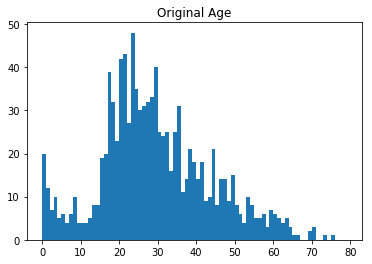

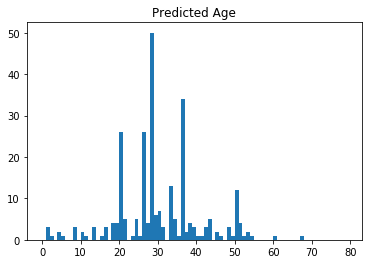

In [8]:
import matplotlib.pyplot as plt
scalar = 80

plt.hist(samples_with_age.Age*scalar, range(scalar))
plt.title("Original Age")
plt.show()

plt.hist(results_age*scalar, range(scalar))
plt.title("Predicted Age")
plt.show()